# Face Generation

In this project, we  define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!


### Get the Data

Used dataset [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

### Pre-processed Data

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.


#### ImageFolder

To create a dataset given a directory of images, it's recommended  to use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets as dset
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    dataset = dset.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.ToTensor(),
                               ]))
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)
    
    return data_loader


## Create a DataLoader

####  Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

* `image_size` **chosen to be ** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [26]:
# Define function hyperparameters
batch_size = 16
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


View some images to check the preprocessing went well.

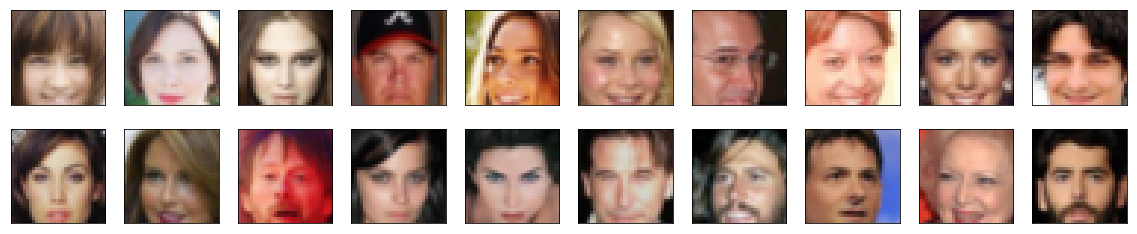

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process your image data and scale it to a pixel range of -1 to 1

We need a  bit of pre-processing; the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    return x * (feature_range[1] - feature_range[0]) + feature_range[0]


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(0.9216)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The  first task will be to define the discriminator. This is a convolutional classifier only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. 


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# This cell contain a helper function
def make_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    INPUT :
        in_channels (int) : the number of the channels of the input image
        out_channels (int) :the number of channels of the output (result of the convolution)
        kernel_size (int or tuple) : the size of the convoluting kernel
        stride OPTIONAL (int) : the convolution's stride
        padding OPTIONAL (int) : one-padding added in the both sides of the input
        batch_norm OPTIONAL (boolean) : add/ or not a batch normalization layer
    OUTPUT:
        convolutional layer with/or without a batch norm layer in a sequential container
    """
    
    layers=[]
    conv_layer = nn.Conv2d(in_channels, out_channels,
                          kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)
    # if batch norm set to True add a batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
   
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        # first layer : input 32 x 32 with no batch norm
        self.conv1 = make_conv(3, conv_dim, 4, batch_norm=False)
        # second layer : input 16 x 16 with batch norm
        self.conv2 = make_conv(conv_dim , conv_dim*2, 4)
        # third layer : input 8 x  8 with batch norm 
        self.conv3 = make_conv(conv_dim*2, conv_dim*4, 4)
        # fourth layer : input 4 x 4 with batch norm 
        self.conv4 = make_conv(conv_dim*4, conv_dim*8, 4)

        # fully connected layer : one output (fake/real)
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        out = self.fc(out)        
        return out


tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [13]:
#This cell is for a helper function 
def make_tconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed convolutional layer, with optional batch normalization.
    INPUT :
        in_channels (int) : the number of the channels of the input image
        out_channels (int) :the number of channels of the output (result of the convolution)
        kernel_size (int or tuple) : the size of the convoluting kernel
        stride OPTIONAL (int) : the convolution's stride
        padding OPTIONAL (int) : one-padding added in the both sides of the input
        batch_norm OPTIONAL (boolean) : add/ or not a batch normalization layer
    OUTPUT:
        transposed convolutional layer with/or without a batch norm layer in a sequential container
    """
    
    layers=[]
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size, stride, padding, bias=False)
    
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        # layers 
        # first convolutional layer : input 2 x 2  
        self.tconv1 = make_tconv(conv_dim*8, conv_dim*4, 4)
        #second convolutional layer : input 4 x 4  
        self.tconv2 = make_tconv(conv_dim*4, conv_dim*2, 4)
        # third convolutional layer : input 8 x 8 
        self.tconv3 = make_tconv(conv_dim*2, conv_dim, 4)
        # last convolutional layer : output 32 x 32 x 3 
        self.tconv4 = make_tconv(conv_dim, 3, 4, batch_norm=False)
        
        
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        
        # last layer 
        out = self.tconv4(out)
        # apply tanh activation
        out = torch.tanh(out)
        
        return out

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of the networks

To help your models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.


In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # get the class name to ensure that we initialise only for convolutional and linear layers
    class_name = m.__class__.__name__
    
    if hasattr(m, 'weight') and (class_name.find('Conv') != -1 or class_name.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # set the bias term to 0 if it exists 
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()
    
    

## Build complete network


In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [27]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

### Training on GPU

Check if we  can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [28]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.


In [29]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9 # performed smoothing 
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake images 
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

## Optimizers


In [30]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

d_lr = 0.0002 
g_lr = 0.0004 
d_optimizer = optim.Adam(D.parameters(),d_lr, betas=(0.2, 0.999))
g_optimizer = optim.Adam(G.parameters(),g_lr, betas=(0.2, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use your functions `real_loss` and `fake_loss` to help  calculate the discriminator losses.

* We train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # loss on real images 
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            #train with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            # loss on fake images
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images 
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()
         

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [32]:
# set number of epochs 
n_epochs = 10

# call training function

losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.4700 | g_loss: 2.0852
Epoch [    1/   10] | d_loss: 0.9598 | g_loss: 1.5635
Epoch [    1/   10] | d_loss: 1.3543 | g_loss: 1.0364
Epoch [    1/   10] | d_loss: 1.3920 | g_loss: 2.3643
Epoch [    1/   10] | d_loss: 1.2089 | g_loss: 1.8852
Epoch [    1/   10] | d_loss: 1.1051 | g_loss: 1.4773
Epoch [    1/   10] | d_loss: 1.1445 | g_loss: 1.0988
Epoch [    1/   10] | d_loss: 1.2483 | g_loss: 1.8581
Epoch [    1/   10] | d_loss: 1.4030 | g_loss: 0.8773
Epoch [    1/   10] | d_loss: 1.4413 | g_loss: 0.9762
Epoch [    1/   10] | d_loss: 1.3198 | g_loss: 2.3552
Epoch [    1/   10] | d_loss: 1.2713 | g_loss: 1.3912
Epoch [    1/   10] | d_loss: 1.2233 | g_loss: 1.0022
Epoch [    1/   10] | d_loss: 1.4616 | g_loss: 0.7082
Epoch [    1/   10] | d_loss: 1.2262 | g_loss: 0.9841
Epoch [    1/   10] | d_loss: 1.4409 | g_loss: 2.2699
Epoch [    1/   10] | d_loss: 1.2370 | g_loss: 1.6373
Epoch [    1/   10] | d_loss: 1.2958 | g_loss: 0.9059
Epoch [    1/   10] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

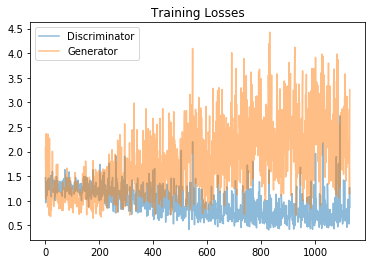

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend();

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [34]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [35]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

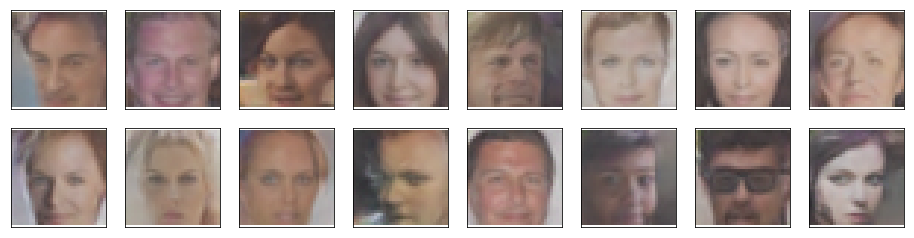

In [36]:
_ = view_samples(-1, samples)

# Reflections : 

The generated samples are blurry but the look like human faces . <br> 
I think the human faces have complex patterns so they require a deeper neural networks to achieve higher quality results . <br>
In the hyper parameters tuning I tried many combinations here are the results that I found :<br> 
- The BCEWithLogits performed better than the mean of squared errors.
- In the optimizer's parameters generally setting beta1 to have a value between 0.2 and 0.35 seemed to improve my results .
- From this paper :  https://arxiv.org/pdf/1706.08500.pdf  I found out that setting the learning rate of the discriminator to be 4 times greater than the learning rate of the generator helped speeding up the training process.
- Setting a mini batch to a small value like 16 or 32 also enhanced the results .
- I think also that training for more epochs will help the model generalize better .